In [1]:
!pip install -qq einops

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import gc
from typing import List, Iterable

from IPython.display import clear_output
gc.enable()

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import StochasticDepth

from einops import rearrange

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm.notebook import tqdm
from glob import glob

seed = 42
pd.set_option('display.max_colwidth', None)

In [3]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


In [4]:
BATCH_SIZE = 16
IMAGE_SIZE = 224
EPOCHS = 50
NUM_CLASSES = 1  

**Sample image with GT mask**

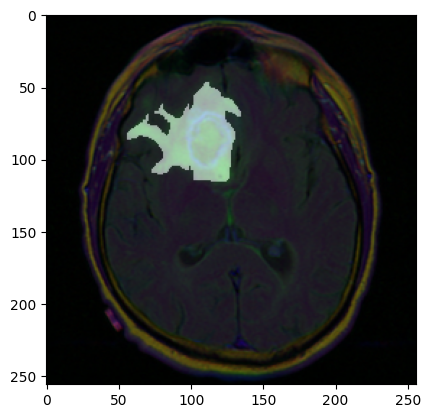

In [5]:
mask = Image.open("../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif")
mask = np.array(mask)[..., np.newaxis]
mask = np.repeat(mask, 3, axis=-1)

image = Image.open("../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif")
image = np.array(image)

image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)

plt.imshow(image)
plt.show()

**Collect images and corresponding masks**

In [6]:
all_paths = glob("../input/lgg-mri-segmentation/kaggle_3m/*/*.tif")
images_paths = sorted([path for path in all_paths if "mask" not in path])
masks_paths = sorted([path[:-9] for path in all_paths if "mask" in path])
masks_paths = [path + "_mask.tif" for path in masks_paths]
del all_paths; gc.collect()

3333

In [7]:
data = pd.DataFrame(data={"image": images_paths, "mask": masks_paths})

x_train, x_valid = train_test_split(data, test_size=500, shuffle=True, random_state=seed)
x_test, x_valid = train_test_split(x_valid, test_size=0.5, shuffle=True, random_state=seed)
x_train = x_train.reset_index(drop=True)
x_valid = x_valid.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

print(f"Train size: {x_train.shape[0]}, validation size: {x_valid.shape[0]}, test size: {x_test.shape[0]}")

Train size: 3429, validation size: 250, test size: 250


In [8]:
x_train.sample(5)

image  \
578   ../input/lgg-mri-segmentation/kaggle_3m\TCGA_DU_5872_19950223\TCGA_DU_5872_19950223_38.tif   
1055  ../input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_7690_19960312\TCGA_HT_7690_19960312_11.tif   
564   ../input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_7881_19981015\TCGA_HT_7881_19981015_40.tif   
2298  ../input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_7686_19950629\TCGA_HT_7686_19950629_14.tif   
3243  ../input/lgg-mri-segmentation/kaggle_3m\TCGA_DU_6401_19831001\TCGA_DU_6401_19831001_44.tif   

                                                                                                 mask  
578   ../input/lgg-mri-segmentation/kaggle_3m\TCGA_DU_5872_19950223\TCGA_DU_5872_19950223_38_mask.tif  
1055  ../input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_7690_19960312\TCGA_HT_7690_19960312_11_mask.tif  
564   ../input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_7881_19981015\TCGA_HT_7881_19981015_40_mask.tif  
2298  ../input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_7686_19950629\TCGA_HT_7686_19950629_14_mask.tif  
3243  ../input/lgg-mri-segmentation/kaggle_3m\TCGA_DU_6401_19831001\TCGA_DU_6401_19831001_44_mask.tif

**Dataset, augmentations, dataloader**

In [9]:
train_transforms = A.Compose([
                      A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, 
                                                    sat_shift_limit=0.2, 
                                                    val_shift_limit=0.2, 
                                                    p=0.2),      
                      A.RandomBrightnessContrast(brightness_limit=0.2, 
                                                 contrast_limit=0.2, 
                                                 p=0.9)],p=0.2),
                      A.ToGray(p=0.1),
                      A.OneOf(
                              [A.HorizontalFlip(p=0.5),
                               A.VerticalFlip(p=0.5),
                               A.RandomRotate90(p=0.5),
                               A.Transpose(p=0.5),
                              ], p=0.5),
                      A.OneOf([
                                A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                                A.GridDistortion(p=0.5),
                                A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
                            ], p=0.8),
                      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
                      A.Cutout(num_holes=8, max_h_size=10, max_w_size=10, fill_value=0, p=0.1),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

valid_transforms = A.Compose([
                      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

invTrans = A.Compose([A.Normalize(mean=[ 0., 0., 0. ],
                                  std=[ 1/0.229, 1/0.224, 1/0.225 ], max_pixel_value=1.0),
                      A.Normalize(mean=[ -0.485, -0.456, -0.406 ],
                                  std=[ 1., 1., 1. ], max_pixel_value=1.0),
                      ], p=1.0)

def inverse_transforms(tensor):
    if tensor.size(0) == 1 and len(tensor.shape) == 4:
        tensor.squeeze_(0)
    sample = {"image": tensor.cpu().detach().numpy().transpose(1,2,0)}
    image = invTrans(**sample)["image"]

    return image

In [10]:
class SegDataset(Dataset):
    def __init__(self, data, transforms):
        self.data = data
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, ix):
        row = self.data.loc[ix].squeeze()
        image = Image.open(row["image"])
        image = np.array(image)
        
        mask = Image.open(row["mask"])
        mask = np.array(mask)
        
        mask = np.where(mask > 127, 255, 0)
        
        sample = {"image": image, "mask": mask}
        sample = self.transforms(**sample)
        
        image, mask = sample["image"], sample["mask"]
        mask = mask[None, ...]
        
        return image, mask / 255.
    
    def collate_fn(self, batch):
        images, masks = list(zip(*batch))
        images, masks = [[tensor[None].to(device) for tensor in btc] for btc in [images, masks]]
        images, masks = [torch.cat(tensors) for tensors in [images, masks]]
        return images, masks 
        # image, mask = batch
        # image = torch.tensor(image).unsqueeze(0).to(device)
        # mask = torch.tensor(mask).unsqueeze(0).to(device)
        # return image, mask

In [11]:
train_ds = SegDataset(x_train, train_transforms)
valid_ds = SegDataset(x_valid, valid_transforms)
test_ds = SegDataset(x_test, valid_transforms)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=valid_ds.collate_fn)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=test_ds.collate_fn)

In [12]:
encoded_inputs = train_ds[0]
print(encoded_inputs[0].shape)
print(encoded_inputs[1].shape)

torch.Size([3, 224, 224])
torch.Size([1, 224, 224])


In [24]:
from transformers import SegformerForSemanticSegmentation
from huggingface_hub import cached_download, hf_hub_url
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=1, 
                                                         
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.bias', 'decode_head.li

In [25]:
def train_one_batch(data, model, optimizer, criterion, threshold=0.5):
    model.train()
    images, masks = data
    masks = masks.squeeze(1)
    optimizer.zero_grad()
    out = model(pixel_values=images, labels=masks).logits  # [B, 1, 56, 56]
    out = nn.functional.interpolate(out, size=masks.shape[-2:], mode="bilinear", align_corners=False)  # [B, 1, 224, 224]
    
    loss = criterion(out, masks)  # [B, 1, 224, 224] of logits and [B, 1, 224, 224] of float zeros and ones

    loss.backward()
    optimizer.step()
    
    out = (torch.sigmoid(out) >= threshold).to(torch.float32)
    performance = criterion(out, masks)  
    
    return loss.item(), 1 - performance.item()

# nn.CrossEntropyLoss()(torch.randn(8,2,224,224), msk.squeeze(1).long())  # [B, 2, 224, 224] and [B, 224, 224]

@torch.no_grad()
def validate_one_batch(data, model, criterion, threshold=0.5):
    model.eval()
    images, masks = data
    masks = masks.squeeze(1)
    out = model(pixel_values=images, labels=masks).logits
    out = nn.functional.interpolate(out, size=masks.shape[-2:], mode="bilinear", align_corners=False)
    
    loss = criterion(out, masks)
    
    out = (torch.sigmoid(out) >= threshold).to(torch.float32)
    performance = criterion(out, masks) 
    
    return loss.item(), 1 - performance.item()

@torch.no_grad()
def test_plot(model):
    model.eval()
    idx = np.random.randint(len(x_test))
    image = Image.open(x_test.iloc[idx, 0]).resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image)
    sample = {"image": image}
    inputs = valid_transforms(**sample)["image"].unsqueeze(0).to(device)
   
    mask = Image.open(x_test.iloc[idx, 1]).resize((IMAGE_SIZE, IMAGE_SIZE))
    
    mask = np.array(mask)[..., np.newaxis]
    mask1 = mask.copy()
    pytorch_mask = torch.from_numpy(mask1)
    reshaped_mask = pytorch_mask.permute(2,0,1)
    mask = np.repeat(mask, 3, axis=-1)
    # print(reshaped_mask.shape)
    # print(inputs.shape)
    reshaped_mask = reshaped_mask.to(device)
    masked_image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)
    out = model(pixel_values=inputs, labels=reshaped_mask).logits
    out = nn.functional.interpolate(out, size=(IMAGE_SIZE, IMAGE_SIZE), mode="bilinear", align_corners=False)
    out = torch.sigmoid(out)
    out = out.detach().cpu().numpy()[0].transpose(1,2,0)
    out = np.where(out >= 0.5, 1, 0)
    out = np.clip(out * 255, 0, 255)
    out = np.repeat(out, 3, axis=-1).astype(np.uint8)

    out_image = cv2.addWeighted(image, 0.5, out, 0.5, 0)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[1].imshow(masked_image)
    axes[1].set_title("Original Mask")
    axes[2].imshow(out_image)
    axes[2].set_title("Predicted Mask")
    plt.tight_layout()
    plt.show()

In [26]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0, path='model.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model=None):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            checkpoint = {
                'model': model,
            }
            torch.save(checkpoint, self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [27]:
class DiceLoss(nn.Module):
    def __init__(self, weight=2, size_average=True):
        super(DiceLoss, self).__init__()
        self.weight = weight

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (self.weight*intersection + smooth)/(inputs.sum() + targets.sum() + smooth + (self.weight - 2)* intersection)  
        
        return 1 - dice

In [28]:
stopper = EarlyStopping(patience=8)
criterion = DiceLoss(2)  
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.00005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-7, factor=0.1)
EPOCHS =100


In [29]:
print_feq = 100

epoch: 1 	step: 1 / 216 	train loss: 0.8731 	train performance: 0.0109 	time: 174.4289 s
epoch: 1 	step: 101 / 216 	train loss: 0.4084 	train performance: 0.0206 	time: 38.6080 s
epoch: 1 	step: 201 / 216 	train loss: 0.3387 	train performance: 0.0166 	time: 342.6967 s
epoch: 2 	step: 1 / 216 	train loss: 0.6278 	train performance: 0.0272 	time: 59.0066 s
epoch: 2 	step: 101 / 216 	train loss: 0.2205 	train performance: 0.0471 	time: 82.2800 s
epoch: 2 	step: 201 / 216 	train loss: 0.2833 	train performance: 0.0212 	time: 54.8560 s
epoch: 3 	step: 1 / 216 	train loss: 0.1540 	train performance: 0.0282 	time: 54.8532 s
epoch: 3 	step: 101 / 216 	train loss: 0.1945 	train performance: 0.0236 	time: 54.9570 s
epoch: 3 	step: 201 / 216 	train loss: 0.1361 	train performance: 0.0604 	time: 55.1575 s
epoch: 4 	step: 1 / 216 	train loss: 0.3480 	train performance: 0.0101 	time: 55.1015 s
epoch: 4 	step: 101 / 216 	train loss: 0.1638 	train performance: 0.0229 	time: 329.9252 s
epoch: 4 	step:

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 5 / 101 	train loss: 0.1982 	valid loss: 0.1546 	train performance 0.0286 	valid performance 0.0276


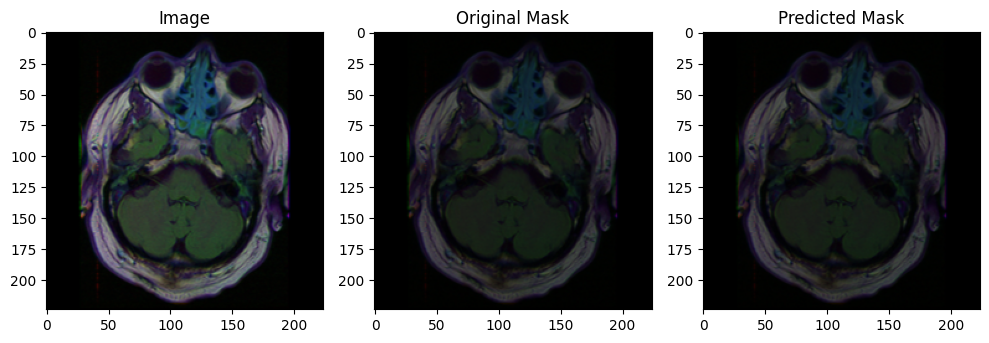

epoch: 6 	step: 1 / 216 	train loss: 0.1669 	train performance: 0.0284 	time: 76.0997 s
epoch: 6 	step: 101 / 216 	train loss: 0.2757 	train performance: 0.0396 	time: 70.5617 s
epoch: 6 	step: 201 / 216 	train loss: 0.4738 	train performance: 0.0315 	time: 69.8618 s
epoch: 7 	step: 1 / 216 	train loss: 0.0935 	train performance: 0.0178 	time: 70.3167 s
epoch: 7 	step: 101 / 216 	train loss: 0.1847 	train performance: 0.0359 	time: 70.4117 s
epoch: 7 	step: 201 / 216 	train loss: 0.1663 	train performance: 0.0170 	time: 70.1629 s
epoch: 8 	step: 1 / 216 	train loss: 0.1149 	train performance: 0.0313 	time: 70.5114 s
epoch: 8 	step: 101 / 216 	train loss: 0.1519 	train performance: 0.0223 	time: 70.9103 s
epoch: 8 	step: 201 / 216 	train loss: 0.1333 	train performance: 0.0410 	time: 71.3140 s
epoch: 9 	step: 1 / 216 	train loss: 0.1315 	train performance: 0.0159 	time: 70.1908 s
epoch: 9 	step: 101 / 216 	train loss: 0.5215 	train performance: 0.0151 	time: 71.1752 s
epoch: 9 	step: 20

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 10 / 101 	train loss: 0.1655 	valid loss: 0.1503 	train performance 0.0292 	valid performance 0.0271


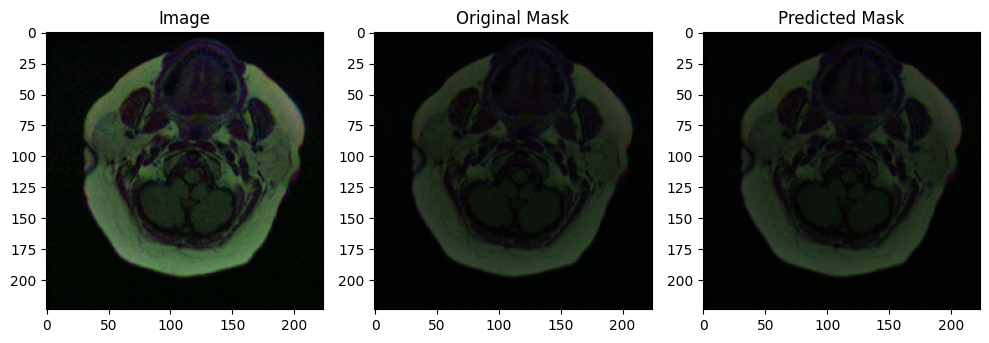

epoch: 11 	step: 1 / 216 	train loss: 0.2157 	train performance: 0.0265 	time: 70.1171 s
epoch: 11 	step: 101 / 216 	train loss: 0.1029 	train performance: 0.0401 	time: 70.5988 s
epoch: 11 	step: 201 / 216 	train loss: 0.1114 	train performance: 0.0466 	time: 70.0602 s
epoch: 12 	step: 1 / 216 	train loss: 0.2471 	train performance: 0.0292 	time: 70.3119 s
epoch: 12 	step: 101 / 216 	train loss: 0.1002 	train performance: 0.0224 	time: 70.7149 s
epoch: 12 	step: 201 / 216 	train loss: 0.1387 	train performance: 0.0472 	time: 70.5622 s
epoch: 13 	step: 1 / 216 	train loss: 0.0898 	train performance: 0.0261 	time: 70.1423 s
epoch: 13 	step: 101 / 216 	train loss: 0.1608 	train performance: 0.0405 	time: 70.5150 s
epoch: 13 	step: 201 / 216 	train loss: 0.3535 	train performance: 0.0469 	time: 70.3120 s
epoch: 14 	step: 1 / 216 	train loss: 0.0937 	train performance: 0.0212 	time: 70.4246 s
epoch: 14 	step: 101 / 216 	train loss: 0.1723 	train performance: 0.0237 	time: 69.9166 s
epoch: 

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 15 / 101 	train loss: 0.1502 	valid loss: 0.1327 	train performance 0.0293 	valid performance 0.0276


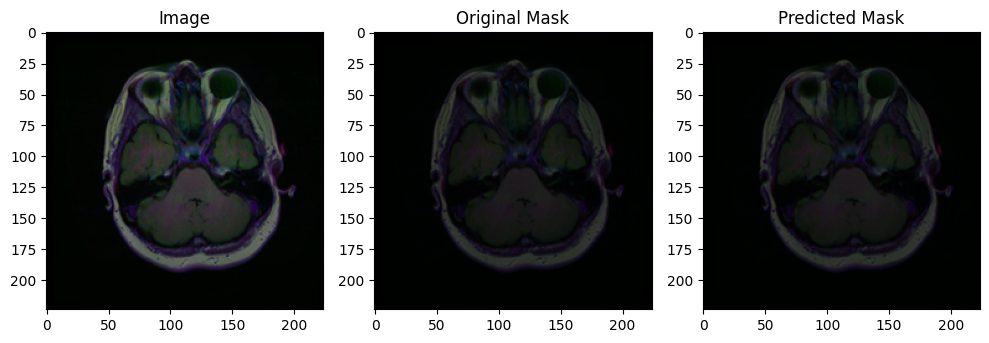

epoch: 16 	step: 1 / 216 	train loss: 0.0799 	train performance: 0.0374 	time: 69.6174 s
epoch: 16 	step: 101 / 216 	train loss: 0.1180 	train performance: 0.0306 	time: 69.5142 s
epoch: 16 	step: 201 / 216 	train loss: 0.3965 	train performance: 0.0074 	time: 70.3088 s
epoch: 17 	step: 1 / 216 	train loss: 0.1704 	train performance: 0.0337 	time: 69.9166 s
epoch: 17 	step: 101 / 216 	train loss: 0.1571 	train performance: 0.0299 	time: 69.4143 s
epoch: 17 	step: 201 / 216 	train loss: 0.1619 	train performance: 0.0441 	time: 70.3369 s
epoch: 18 	step: 1 / 216 	train loss: 0.1314 	train performance: 0.0177 	time: 69.9305 s
epoch: 18 	step: 101 / 216 	train loss: 0.0838 	train performance: 0.0268 	time: 70.9182 s
epoch: 18 	step: 201 / 216 	train loss: 0.1193 	train performance: 0.0349 	time: 70.6159 s
epoch: 19 	step: 1 / 216 	train loss: 0.2726 	train performance: 0.0277 	time: 70.5145 s
epoch: 19 	step: 101 / 216 	train loss: 0.2016 	train performance: 0.0134 	time: 70.2122 s
epoch: 

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 20 / 101 	train loss: 0.1446 	valid loss: 0.1279 	train performance 0.0289 	valid performance 0.0281


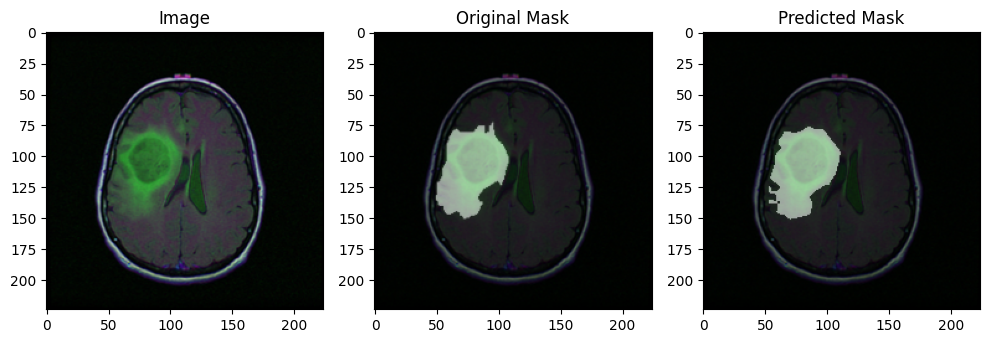

epoch: 21 	step: 1 / 216 	train loss: 0.1747 	train performance: 0.0318 	time: 69.9130 s
epoch: 21 	step: 101 / 216 	train loss: 0.2000 	train performance: 0.0132 	time: 69.4566 s
epoch: 21 	step: 201 / 216 	train loss: 0.1577 	train performance: 0.0222 	time: 69.8179 s
epoch: 22 	step: 1 / 216 	train loss: 0.1377 	train performance: 0.0443 	time: 70.8145 s
epoch: 22 	step: 101 / 216 	train loss: 0.1824 	train performance: 0.0130 	time: 70.2122 s
epoch: 22 	step: 201 / 216 	train loss: 0.1333 	train performance: 0.0097 	time: 70.8106 s
epoch: 23 	step: 1 / 216 	train loss: 0.1193 	train performance: 0.0400 	time: 71.6087 s
epoch: 23 	step: 101 / 216 	train loss: 0.1027 	train performance: 0.0270 	time: 69.7587 s
epoch: 23 	step: 201 / 216 	train loss: 0.1291 	train performance: 0.0187 	time: 70.3179 s
epoch: 24 	step: 1 / 216 	train loss: 0.0651 	train performance: 0.0234 	time: 70.5163 s
epoch: 24 	step: 101 / 216 	train loss: 0.1316 	train performance: 0.0290 	time: 70.1124 s
epoch: 

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 25 / 101 	train loss: 0.1530 	valid loss: 0.1210 	train performance 0.0291 	valid performance 0.0278


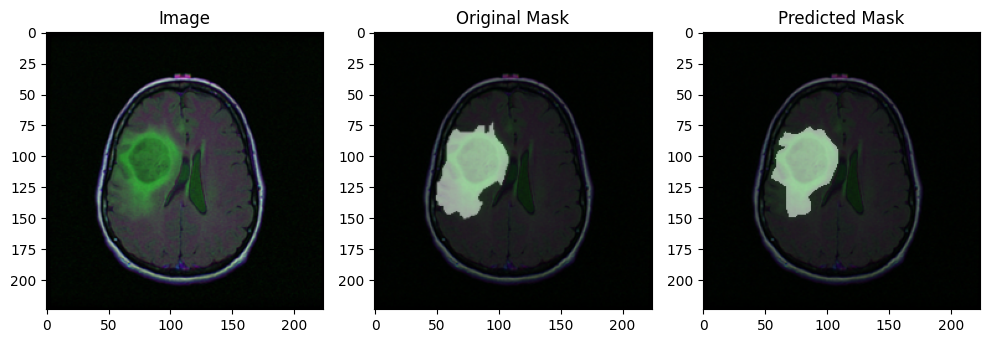

epoch: 26 	step: 1 / 216 	train loss: 0.1248 	train performance: 0.0450 	time: 87.3710 s
epoch: 26 	step: 101 / 216 	train loss: 0.3504 	train performance: 0.0145 	time: 70.0128 s
epoch: 26 	step: 201 / 216 	train loss: 0.0875 	train performance: 0.0239 	time: 70.4187 s
epoch: 27 	step: 1 / 216 	train loss: 0.1237 	train performance: 0.0388 	time: 70.1126 s
epoch: 27 	step: 101 / 216 	train loss: 0.3312 	train performance: 0.0043 	time: 71.6086 s
epoch: 27 	step: 201 / 216 	train loss: 0.1441 	train performance: 0.0516 	time: 70.1159 s
epoch: 28 	step: 1 / 216 	train loss: 0.1344 	train performance: 0.0208 	time: 69.2150 s
epoch: 28 	step: 101 / 216 	train loss: 0.1884 	train performance: 0.0294 	time: 69.6683 s
epoch: 28 	step: 201 / 216 	train loss: 0.1756 	train performance: 0.0093 	time: 69.4144 s
epoch: 29 	step: 1 / 216 	train loss: 0.0939 	train performance: 0.0477 	time: 69.8176 s
epoch: 29 	step: 101 / 216 	train loss: 0.1944 	train performance: 0.0356 	time: 70.8141 s
epoch: 

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 30 / 101 	train loss: 0.1593 	valid loss: 0.1271 	train performance 0.0290 	valid performance 0.0279


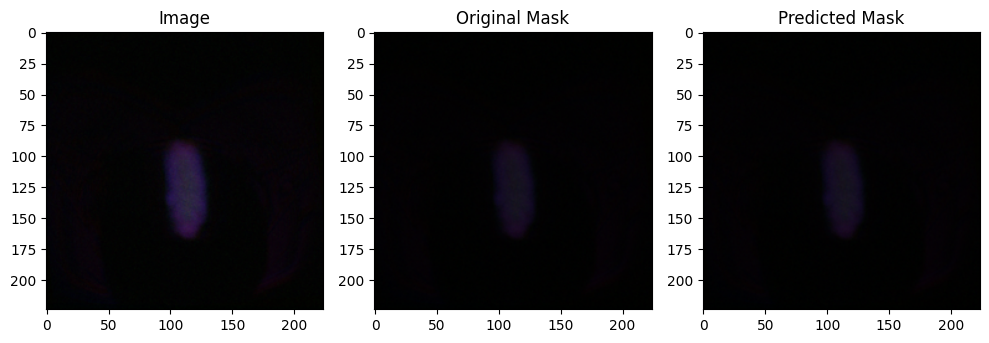

epoch: 31 	step: 1 / 216 	train loss: 0.0970 	train performance: 0.0188 	time: 70.5283 s
epoch: 31 	step: 101 / 216 	train loss: 0.1788 	train performance: 0.0257 	time: 70.0186 s
epoch: 31 	step: 201 / 216 	train loss: 0.0931 	train performance: 0.0201 	time: 70.3120 s
epoch: 32 	step: 1 / 216 	train loss: 0.1181 	train performance: 0.0387 	time: 69.9169 s
epoch: 32 	step: 101 / 216 	train loss: 0.1343 	train performance: 0.0303 	time: 69.7206 s
epoch: 32 	step: 201 / 216 	train loss: 0.0635 	train performance: 0.0240 	time: 69.9064 s
epoch: 33 	step: 1 / 216 	train loss: 0.1374 	train performance: 0.0312 	time: 69.8133 s
epoch: 33 	step: 101 / 216 	train loss: 0.1234 	train performance: 0.0161 	time: 70.4175 s
epoch: 33 	step: 201 / 216 	train loss: 0.0884 	train performance: 0.0536 	time: 70.2190 s
epoch: 34 	step: 1 / 216 	train loss: 0.2172 	train performance: 0.0313 	time: 70.2728 s
epoch: 34 	step: 101 / 216 	train loss: 0.1414 	train performance: 0.0414 	time: 69.3212 s
epoch: 

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 35 / 101 	train loss: 0.1289 	valid loss: 0.1232 	train performance 0.0289 	valid performance 0.0278


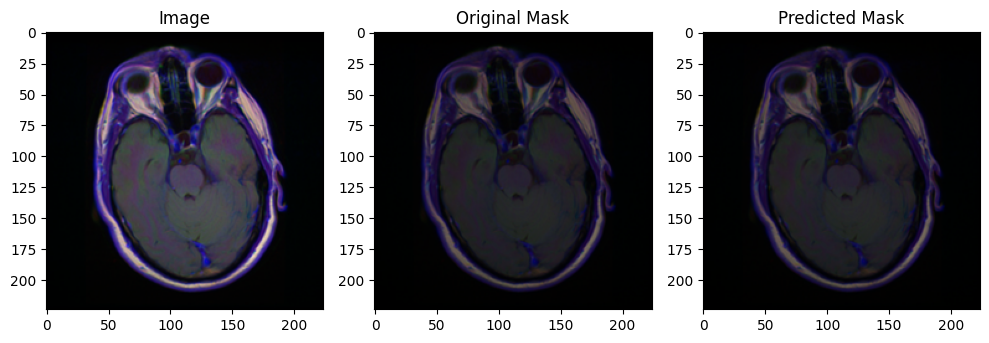

epoch: 36 	step: 1 / 216 	train loss: 0.0985 	train performance: 0.0530 	time: 70.0185 s
epoch: 36 	step: 101 / 216 	train loss: 0.1543 	train performance: 0.0276 	time: 70.8567 s
epoch: 36 	step: 201 / 216 	train loss: 0.1045 	train performance: 0.0353 	time: 70.6639 s
epoch: 37 	step: 1 / 216 	train loss: 0.0981 	train performance: 0.0329 	time: 69.7136 s
epoch: 37 	step: 101 / 216 	train loss: 0.1864 	train performance: 0.0114 	time: 70.2122 s
epoch: 37 	step: 201 / 216 	train loss: 0.0765 	train performance: 0.0467 	time: 70.1125 s
epoch: 38 	step: 1 / 216 	train loss: 0.1768 	train performance: 0.0197 	time: 70.3997 s
epoch: 38 	step: 101 / 216 	train loss: 0.0598 	train performance: 0.0397 	time: 70.7990 s
epoch: 38 	step: 201 / 216 	train loss: 0.0926 	train performance: 0.0199 	time: 70.0175 s
epoch: 39 	step: 1 / 216 	train loss: 0.5917 	train performance: 0.0036 	time: 69.9131 s
epoch: 39 	step: 101 / 216 	train loss: 0.1391 	train performance: 0.0416 	time: 69.4326 s
epoch: 

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 40 / 101 	train loss: 0.1673 	valid loss: 0.1486 	train performance 0.0288 	valid performance 0.0281


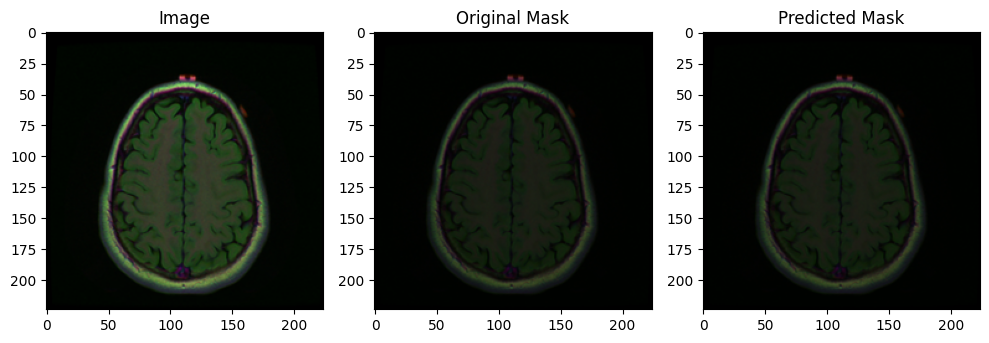

epoch: 41 	step: 1 / 216 	train loss: 0.0967 	train performance: 0.0227 	time: 70.6111 s
epoch: 41 	step: 101 / 216 	train loss: 0.0866 	train performance: 0.0376 	time: 70.4117 s
epoch: 41 	step: 201 / 216 	train loss: 0.1523 	train performance: 0.0202 	time: 70.8107 s
epoch: 42 	step: 1 / 216 	train loss: 0.1483 	train performance: 0.0100 	time: 70.8106 s
epoch: 42 	step: 101 / 216 	train loss: 0.0913 	train performance: 0.0483 	time: 69.5230 s
epoch: 42 	step: 201 / 216 	train loss: 0.0876 	train performance: 0.0380 	time: 69.6709 s
epoch: 43 	step: 1 / 216 	train loss: 0.1511 	train performance: 0.0281 	time: 70.6151 s
epoch: 43 	step: 101 / 216 	train loss: 0.1475 	train performance: 0.0218 	time: 72.0158 s
epoch: 43 	step: 201 / 216 	train loss: 0.1063 	train performance: 0.0303 	time: 70.8106 s
epoch: 44 	step: 1 / 216 	train loss: 0.1324 	train performance: 0.0211 	time: 70.7144 s
epoch: 44 	step: 101 / 216 	train loss: 0.1867 	train performance: 0.0391 	time: 70.3234 s
epoch: 

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 45 / 101 	train loss: 0.1314 	valid loss: 0.1172 	train performance 0.0293 	valid performance 0.0278


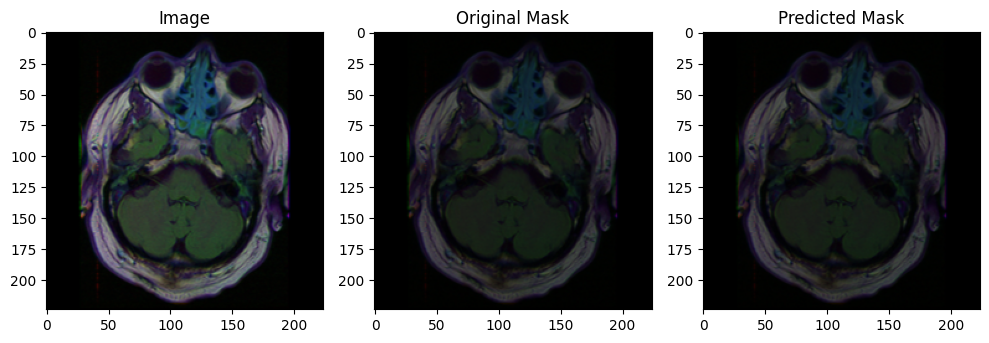

epoch: 46 	step: 1 / 216 	train loss: 0.0925 	train performance: 0.0642 	time: 70.4118 s
epoch: 46 	step: 101 / 216 	train loss: 0.0919 	train performance: 0.0360 	time: 70.6110 s
epoch: 46 	step: 201 / 216 	train loss: 0.1141 	train performance: 0.0396 	time: 70.7251 s
epoch: 47 	step: 1 / 216 	train loss: 0.1415 	train performance: 0.0063 	time: 70.2122 s
epoch: 47 	step: 101 / 216 	train loss: 0.0944 	train performance: 0.0355 	time: 70.2180 s
epoch: 47 	step: 201 / 216 	train loss: 0.1236 	train performance: 0.0317 	time: 70.2162 s
epoch: 48 	step: 1 / 216 	train loss: 0.0994 	train performance: 0.0160 	time: 70.1437 s
epoch: 48 	step: 101 / 216 	train loss: 0.1816 	train performance: 0.0317 	time: 69.9209 s
epoch: 48 	step: 201 / 216 	train loss: 0.1228 	train performance: 0.0368 	time: 70.2169 s
epoch: 49 	step: 1 / 216 	train loss: 0.0919 	train performance: 0.0311 	time: 70.0128 s
epoch: 49 	step: 101 / 216 	train loss: 0.0798 	train performance: 0.0375 	time: 70.7112 s
epoch: 

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 50 / 101 	train loss: 0.1361 	valid loss: 0.1133 	train performance 0.0288 	valid performance 0.0278


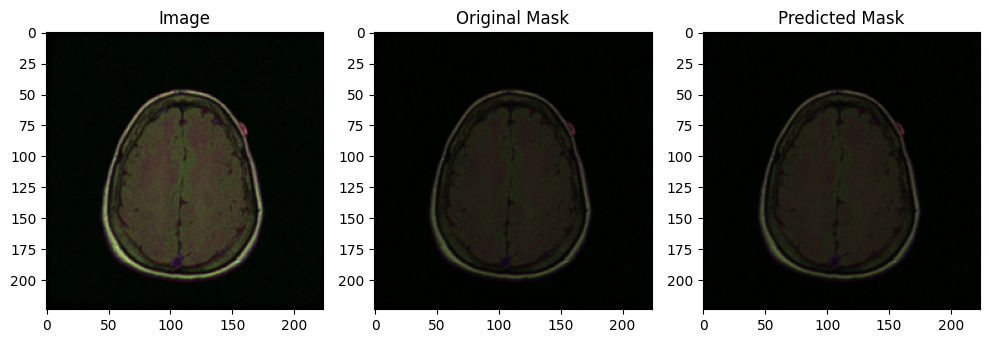

epoch: 51 	step: 1 / 216 	train loss: 0.1527 	train performance: 0.0166 	time: 70.0768 s
epoch: 51 	step: 101 / 216 	train loss: 0.1239 	train performance: 0.0284 	time: 71.3093 s
epoch: 51 	step: 201 / 216 	train loss: 0.0824 	train performance: 0.0555 	time: 70.3120 s
epoch: 52 	step: 1 / 216 	train loss: 0.0762 	train performance: 0.0107 	time: 69.8170 s
epoch: 52 	step: 101 / 216 	train loss: 0.1429 	train performance: 0.0348 	time: 69.3193 s
epoch: 52 	step: 201 / 216 	train loss: 0.1230 	train performance: 0.0292 	time: 71.1098 s
epoch: 53 	step: 1 / 216 	train loss: 0.1002 	train performance: 0.0257 	time: 70.0175 s
epoch: 53 	step: 101 / 216 	train loss: 0.1295 	train performance: 0.0388 	time: 69.5186 s
epoch: 53 	step: 201 / 216 	train loss: 0.1035 	train performance: 0.0280 	time: 69.8172 s
epoch: 54 	step: 1 / 216 	train loss: 0.1156 	train performance: 0.0262 	time: 70.3121 s
epoch: 54 	step: 101 / 216 	train loss: 0.1174 	train performance: 0.0200 	time: 70.5115 s
epoch: 

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 55 / 101 	train loss: 0.1594 	valid loss: 0.1319 	train performance 0.0288 	valid performance 0.0277


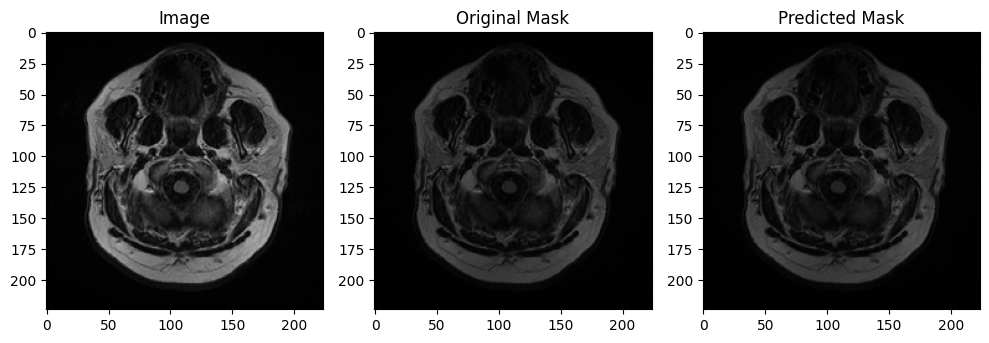

epoch: 56 	step: 1 / 216 	train loss: 0.0921 	train performance: 0.0562 	time: 70.4156 s
epoch: 56 	step: 101 / 216 	train loss: 0.2125 	train performance: 0.0036 	time: 70.8153 s
epoch: 56 	step: 201 / 216 	train loss: 0.0455 	train performance: 0.0241 	time: 70.5155 s
epoch: 57 	step: 1 / 216 	train loss: 0.0831 	train performance: 0.0343 	time: 69.8132 s
epoch: 57 	step: 101 / 216 	train loss: 0.1038 	train performance: 0.0412 	time: 71.3147 s
epoch: 57 	step: 201 / 216 	train loss: 0.0960 	train performance: 0.0191 	time: 70.3133 s
epoch: 58 	step: 1 / 216 	train loss: 0.1469 	train performance: 0.0267 	time: 70.6111 s
epoch: 58 	step: 101 / 216 	train loss: 0.1006 	train performance: 0.0354 	time: 69.9131 s
epoch: 58 	step: 201 / 216 	train loss: 0.0808 	train performance: 0.0430 	time: 69.9090 s
epoch: 59 	step: 1 / 216 	train loss: 0.1439 	train performance: 0.0253 	time: 70.2177 s
epoch: 59 	step: 101 / 216 	train loss: 0.0905 	train performance: 0.0331 	time: 70.9296 s
epoch: 

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 60 / 101 	train loss: 0.1493 	valid loss: 0.1239 	train performance 0.0287 	valid performance 0.0279


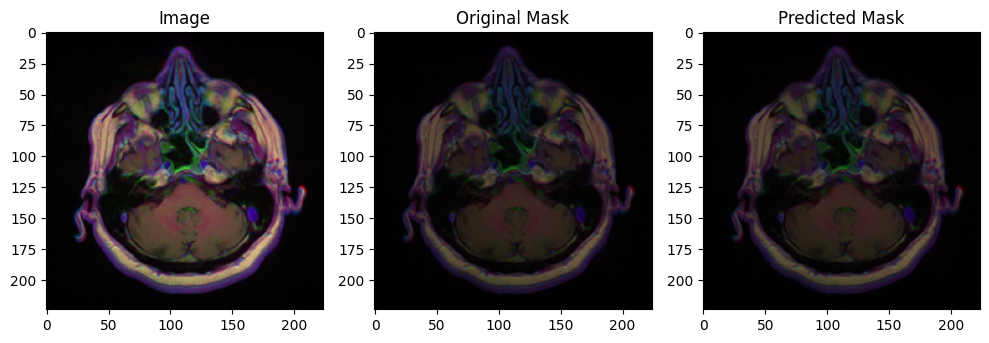

epoch: 61 	step: 1 / 216 	train loss: 0.0860 	train performance: 0.0110 	time: 70.3119 s
epoch: 61 	step: 101 / 216 	train loss: 0.1043 	train performance: 0.0172 	time: 69.9266 s
epoch: 61 	step: 201 / 216 	train loss: 0.1761 	train performance: 0.0190 	time: 70.7161 s
epoch: 62 	step: 1 / 216 	train loss: 0.1935 	train performance: 0.0166 	time: 71.3095 s
epoch: 62 	step: 101 / 216 	train loss: 0.2876 	train performance: 0.0103 	time: 69.9161 s
epoch: 62 	step: 201 / 216 	train loss: 0.0725 	train performance: 0.0697 	time: 69.9012 s
epoch: 63 	step: 1 / 216 	train loss: 0.2271 	train performance: 0.0063 	time: 69.7694 s
epoch: 63 	step: 101 / 216 	train loss: 0.0942 	train performance: 0.0585 	time: 70.7144 s
epoch: 63 	step: 201 / 216 	train loss: 0.0967 	train performance: 0.0267 	time: 70.2123 s
epoch: 64 	step: 1 / 216 	train loss: 0.0823 	train performance: 0.0398 	time: 70.6070 s
epoch: 64 	step: 101 / 216 	train loss: 0.1872 	train performance: 0.0151 	time: 70.2179 s
epoch: 

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 65 / 101 	train loss: 0.1375 	valid loss: 0.1179 	train performance 0.0291 	valid performance 0.0278


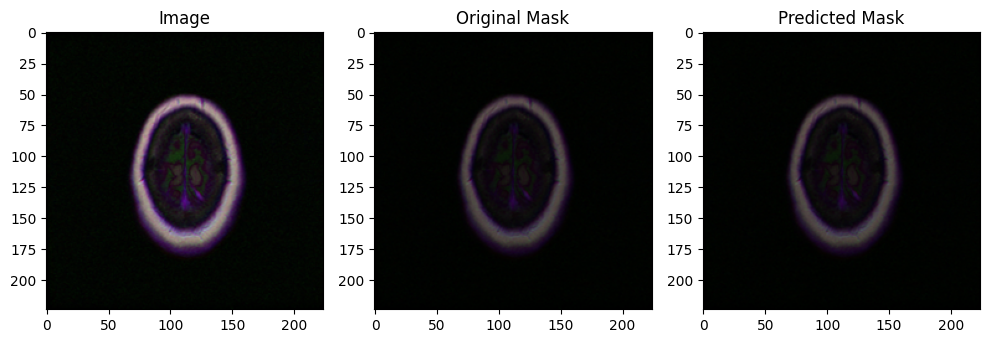

epoch: 66 	step: 1 / 216 	train loss: 0.2380 	train performance: 0.0070 	time: 70.5187 s
epoch: 66 	step: 101 / 216 	train loss: 0.0615 	train performance: 0.0284 	time: 69.4198 s
epoch: 66 	step: 201 / 216 	train loss: 0.1323 	train performance: 0.0126 	time: 70.1125 s
epoch: 67 	step: 1 / 216 	train loss: 0.0848 	train performance: 0.0276 	time: 69.9130 s
epoch: 67 	step: 101 / 216 	train loss: 0.0806 	train performance: 0.0194 	time: 70.0128 s
epoch: 67 	step: 201 / 216 	train loss: 0.0603 	train performance: 0.0566 	time: 70.2160 s
epoch: 68 	step: 1 / 216 	train loss: 0.2678 	train performance: 0.0101 	time: 70.0541 s
epoch: 68 	step: 101 / 216 	train loss: 0.0916 	train performance: 0.0377 	time: 70.3159 s
epoch: 68 	step: 201 / 216 	train loss: 0.1332 	train performance: 0.0286 	time: 70.1160 s
epoch: 69 	step: 1 / 216 	train loss: 0.1218 	train performance: 0.0297 	time: 71.4090 s
epoch: 69 	step: 101 / 216 	train loss: 0.2394 	train performance: 0.0388 	time: 70.1126 s
epoch: 

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 70 / 101 	train loss: 0.1284 	valid loss: 0.1190 	train performance 0.0294 	valid performance 0.0278


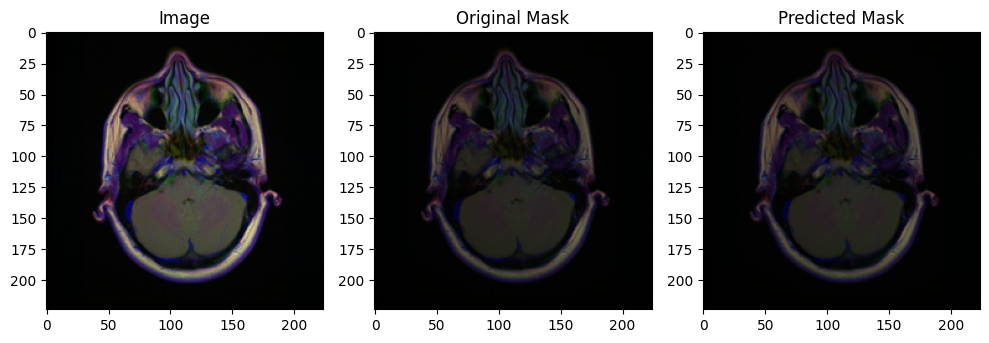

epoch: 71 	step: 1 / 216 	train loss: 0.1063 	train performance: 0.0241 	time: 71.2136 s
epoch: 71 	step: 101 / 216 	train loss: 0.0817 	train performance: 0.0213 	time: 69.9166 s
epoch: 71 	step: 201 / 216 	train loss: 0.1947 	train performance: 0.0099 	time: 69.3146 s
epoch: 72 	step: 1 / 216 	train loss: 0.2688 	train performance: 0.0076 	time: 69.5210 s
epoch: 72 	step: 101 / 216 	train loss: 0.1154 	train performance: 0.0241 	time: 69.8460 s
epoch: 72 	step: 201 / 216 	train loss: 0.1679 	train performance: 0.0170 	time: 69.7180 s
epoch: 73 	step: 1 / 216 	train loss: 0.1402 	train performance: 0.0309 	time: 70.3120 s
epoch: 73 	step: 101 / 216 	train loss: 0.1498 	train performance: 0.0237 	time: 70.2161 s
epoch: 73 	step: 201 / 216 	train loss: 0.1268 	train performance: 0.0200 	time: 71.2202 s
epoch: 74 	step: 1 / 216 	train loss: 0.0884 	train performance: 0.0443 	time: 70.2421 s
epoch: 74 	step: 101 / 216 	train loss: 0.0500 	train performance: 0.0044 	time: 70.3121 s
epoch: 

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 75 / 101 	train loss: 0.1217 	valid loss: 0.1106 	train performance 0.0291 	valid performance 0.0278


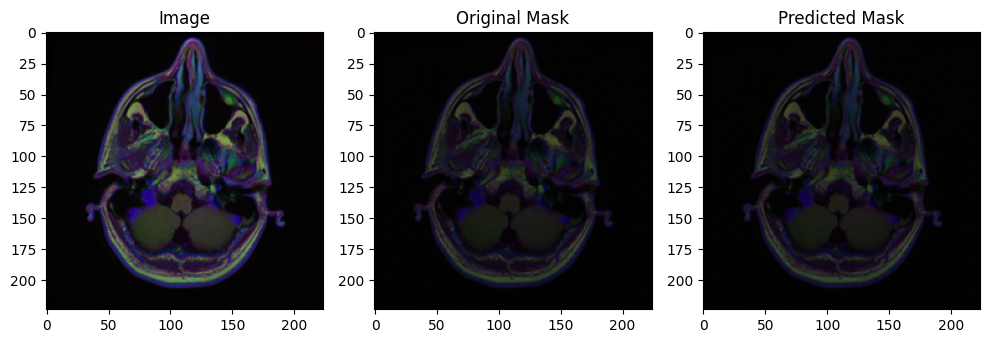

epoch: 76 	step: 1 / 216 	train loss: 0.1192 	train performance: 0.0283 	time: 90.2586 s
epoch: 76 	step: 101 / 216 	train loss: 0.1215 	train performance: 0.0389 	time: 70.3141 s
epoch: 76 	step: 201 / 216 	train loss: 0.8126 	train performance: 0.0000 	time: 70.0175 s
epoch: 77 	step: 1 / 216 	train loss: 0.1964 	train performance: 0.0427 	time: 70.1172 s
epoch: 77 	step: 101 / 216 	train loss: 0.2794 	train performance: 0.0135 	time: 70.4151 s
epoch: 77 	step: 201 / 216 	train loss: 0.1239 	train performance: 0.0148 	time: 70.6147 s
epoch: 78 	step: 1 / 216 	train loss: 0.1897 	train performance: 0.0252 	time: 70.1165 s
epoch: 78 	step: 101 / 216 	train loss: 0.0659 	train performance: 0.0361 	time: 70.7110 s
epoch: 78 	step: 201 / 216 	train loss: 0.0938 	train performance: 0.0298 	time: 70.4166 s
epoch: 79 	step: 1 / 216 	train loss: 0.1764 	train performance: 0.0228 	time: 70.3703 s
epoch: 79 	step: 101 / 216 	train loss: 0.1208 	train performance: 0.0299 	time: 69.9169 s
epoch: 

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 80 / 101 	train loss: 0.1275 	valid loss: 0.1182 	train performance 0.0291 	valid performance 0.0276


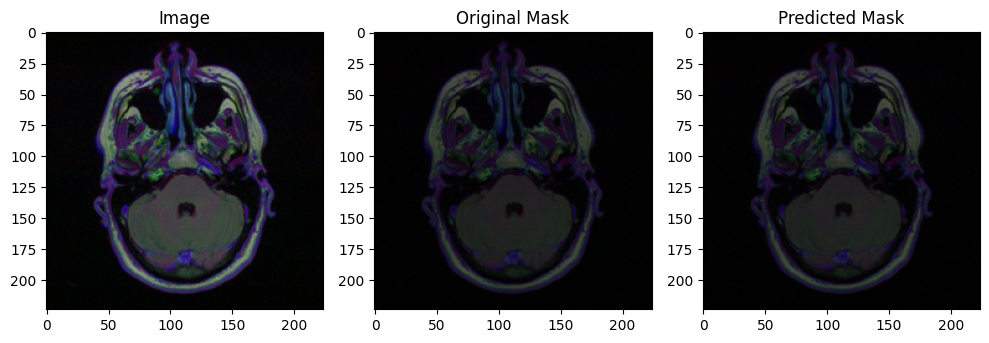

epoch: 81 	step: 1 / 216 	train loss: 0.0698 	train performance: 0.0406 	time: 70.4319 s
epoch: 81 	step: 101 / 216 	train loss: 0.0969 	train performance: 0.0360 	time: 69.3637 s
epoch: 81 	step: 201 / 216 	train loss: 0.2113 	train performance: 0.0149 	time: 71.3287 s
epoch: 82 	step: 1 / 216 	train loss: 0.0752 	train performance: 0.0505 	time: 70.7144 s
epoch: 82 	step: 101 / 216 	train loss: 0.1090 	train performance: 0.0468 	time: 71.1142 s
epoch: 82 	step: 201 / 216 	train loss: 0.1203 	train performance: 0.0484 	time: 70.5321 s
epoch: 83 	step: 1 / 216 	train loss: 0.1229 	train performance: 0.0279 	time: 70.6151 s
epoch: 83 	step: 101 / 216 	train loss: 0.1102 	train performance: 0.0214 	time: 69.9605 s
epoch: 83 	step: 201 / 216 	train loss: 0.0930 	train performance: 0.0434 	time: 70.8106 s
epoch: 84 	step: 1 / 216 	train loss: 0.1629 	train performance: 0.0263 	time: 70.1156 s
epoch: 84 	step: 101 / 216 	train loss: 0.1433 	train performance: 0.0424 	time: 71.2153 s
epoch: 

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 85 / 101 	train loss: 0.1348 	valid loss: 0.1129 	train performance 0.0291 	valid performance 0.0280


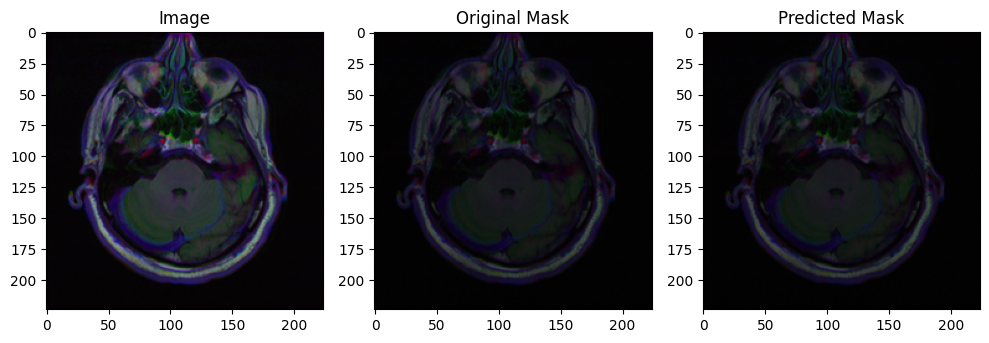

epoch: 86 	step: 1 / 216 	train loss: 0.0954 	train performance: 0.0438 	time: 70.3120 s
epoch: 86 	step: 101 / 216 	train loss: 0.0838 	train performance: 0.0432 	time: 70.5115 s
epoch: 86 	step: 201 / 216 	train loss: 0.0595 	train performance: 0.0188 	time: 69.8171 s
epoch: 87 	step: 1 / 216 	train loss: 0.1215 	train performance: 0.0297 	time: 70.3165 s
epoch: 87 	step: 101 / 216 	train loss: 0.0932 	train performance: 0.0415 	time: 69.8167 s
epoch: 87 	step: 201 / 216 	train loss: 0.1521 	train performance: 0.0210 	time: 70.6112 s
epoch: 88 	step: 1 / 216 	train loss: 0.0759 	train performance: 0.0426 	time: 69.9219 s
epoch: 88 	step: 101 / 216 	train loss: 0.1379 	train performance: 0.0073 	time: 70.0209 s
epoch: 88 	step: 201 / 216 	train loss: 0.0604 	train performance: 0.0405 	time: 70.9692 s
epoch: 89 	step: 1 / 216 	train loss: 0.1772 	train performance: 0.0078 	time: 70.5114 s
epoch: 89 	step: 101 / 216 	train loss: 0.1436 	train performance: 0.0462 	time: 70.3151 s
epoch: 

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 90 / 101 	train loss: 0.1244 	valid loss: 0.1192 	train performance 0.0293 	valid performance 0.0278


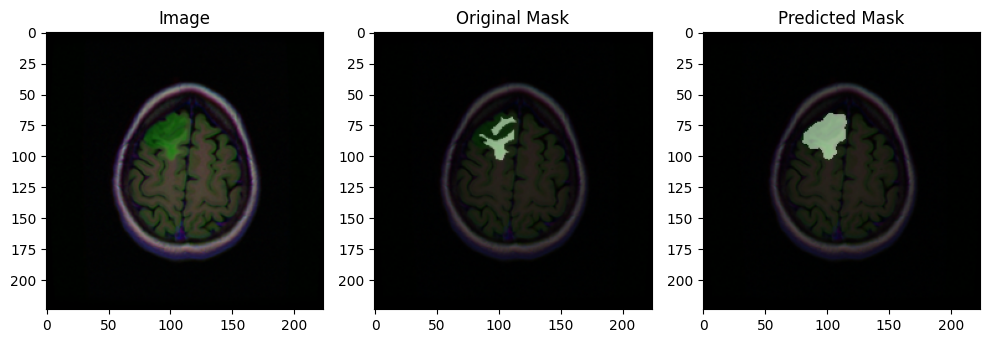

epoch: 91 	step: 1 / 216 	train loss: 0.1832 	train performance: 0.0067 	time: 70.5779 s
epoch: 91 	step: 101 / 216 	train loss: 0.1483 	train performance: 0.0597 	time: 69.6778 s
epoch: 91 	step: 201 / 216 	train loss: 0.0850 	train performance: 0.0252 	time: 70.2169 s
epoch: 92 	step: 1 / 216 	train loss: 0.0853 	train performance: 0.0040 	time: 69.9189 s
epoch: 92 	step: 101 / 216 	train loss: 0.1310 	train performance: 0.0701 	time: 70.1160 s
epoch: 92 	step: 201 / 216 	train loss: 0.2312 	train performance: 0.0305 	time: 70.8267 s
epoch: 93 	step: 1 / 216 	train loss: 0.0742 	train performance: 0.0227 	time: 69.3203 s
epoch: 93 	step: 101 / 216 	train loss: 0.1427 	train performance: 0.0210 	time: 70.3118 s
epoch: 93 	step: 201 / 216 	train loss: 0.1587 	train performance: 0.0310 	time: 70.2157 s
epoch: 94 	step: 1 / 216 	train loss: 0.1377 	train performance: 0.0305 	time: 70.9143 s
epoch: 94 	step: 101 / 216 	train loss: 0.0769 	train performance: 0.0298 	time: 69.6545 s
epoch: 

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 95 / 101 	train loss: 0.1399 	valid loss: 0.1202 	train performance 0.0290 	valid performance 0.0279


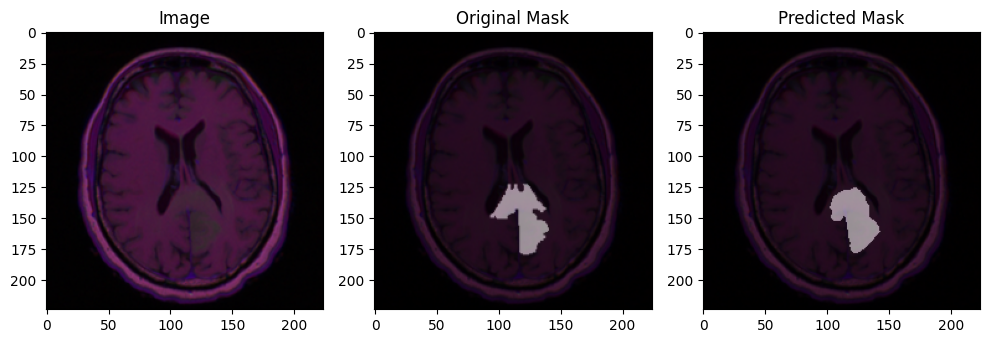

epoch: 96 	step: 1 / 216 	train loss: 0.1128 	train performance: 0.0607 	time: 70.3156 s
epoch: 96 	step: 101 / 216 	train loss: 0.1483 	train performance: 0.0334 	time: 69.8251 s
epoch: 96 	step: 201 / 216 	train loss: 0.1248 	train performance: 0.0368 	time: 70.7156 s
epoch: 97 	step: 1 / 216 	train loss: 0.1238 	train performance: 0.0169 	time: 70.0163 s
epoch: 97 	step: 101 / 216 	train loss: 0.1984 	train performance: 0.0195 	time: 70.3120 s
epoch: 97 	step: 201 / 216 	train loss: 0.0709 	train performance: 0.0424 	time: 71.3707 s
epoch: 98 	step: 1 / 216 	train loss: 0.0772 	train performance: 0.0465 	time: 71.0101 s
epoch: 98 	step: 101 / 216 	train loss: 0.0955 	train performance: 0.0441 	time: 70.0337 s
epoch: 98 	step: 201 / 216 	train loss: 0.1748 	train performance: 0.0321 	time: 70.7110 s
epoch: 99 	step: 1 / 216 	train loss: 0.1018 	train performance: 0.0444 	time: 70.5114 s
epoch: 99 	step: 101 / 216 	train loss: 0.0943 	train performance: 0.0225 	time: 69.8164 s
epoch: 

  0%|          | 0/16 [00:00<?, ?it/s]

epoch: 100 / 101 	train loss: 0.1267 	valid loss: 0.1137 	train performance 0.0291 	valid performance 0.0279


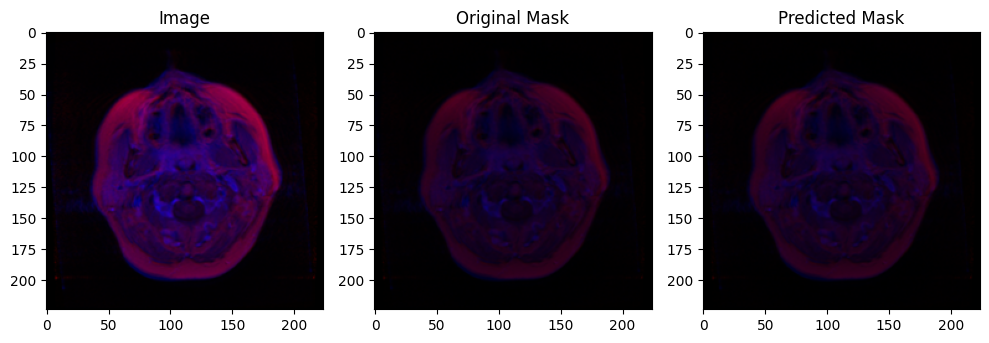

In [31]:
import time
model.to(device)
for epoch in range(1, EPOCHS+1):

    train_loss, train_performances = [], []
    for step, batch in enumerate(train_dl):
        time_1 = time.time()
        
        loss, performance = train_one_batch(batch, model, optimizer, criterion)

        train_loss.append(loss)
        train_performances.append(performance)
        
        if step % print_feq == 0:
            print('epoch:', epoch, 
                  '\tstep:', step+1, '/', len(train_dl) + 1,
                  '\ttrain loss:', '{:.4f}'.format(loss),
                  '\ttrain performance:','{:.4f}'.format(performance),
                  '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_feq), 's')
    if epoch % 5 == 0:
        valid_loss, valid_performances = [], []
        for step, batch in enumerate(tqdm(valid_dl)):
            loss, performance = validate_one_batch(batch, model, criterion)
            
            valid_loss.append(loss)
            valid_performances.append(performance)
            
        print('epoch:', epoch, '/', EPOCHS+1,
                '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
                '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
                '\ttrain performance', '{:.4f}'.format(np.mean(train_performances)),
                '\tvalid performance', '{:.4f}'.format(np.mean(valid_performances)))
    
        test_plot(model)
    
    # stopper(np.mean(valid_loss))
    # scheduler.step(np.mean(valid_loss))

In [32]:
torch.save(model.state_dict(), 'segformer_fine-tuned-100.pt')


In [45]:
def test_all_plot(model):
    model.eval()
    for idx in range(len(x_valid)):
        image = Image.open(x_valid.iloc[idx, 0]).resize((IMAGE_SIZE, IMAGE_SIZE))
        image = np.array(image)
        sample = {"image": image}
        inputs = valid_transforms(**sample)["image"].unsqueeze(0).to(device)
        
        mask = Image.open(x_valid.iloc[idx, 1]).resize((IMAGE_SIZE, IMAGE_SIZE))
        mask = np.array(mask)[..., np.newaxis]
        mask1 = mask.copy()
        pytorch_mask = torch.from_numpy(mask1)
        reshaped_mask = pytorch_mask.permute(2,0,1)
        # print(reshaped_mask.shape)
        # print(inputs.shape)
        reshaped_mask = reshaped_mask.to(device)
        mask = np.repeat(mask, 3, axis=-1)
        
        masked_image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)
        
       
        out = model(pixel_values=inputs, labels=reshaped_mask).logits
        out = nn.functional.interpolate(out, size=(IMAGE_SIZE, IMAGE_SIZE), mode="bilinear", align_corners=False)
        out = torch.sigmoid(out)
        out = out.detach().cpu().numpy()[0].transpose(1,2,0)
        out = np.where(out >= 0.5, 1, 0)
        out = np.clip(out * 255, 0, 255)
        out = np.repeat(out, 3, axis=-1).astype(np.uint8)

        out_image = cv2.addWeighted(image, 0.5, out, 0.5, 0)
        
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
        axes[0].imshow(image)
        axes[0].set_title("Image")
        axes[1].imshow(masked_image)
        axes[1].set_title("Original Mask")
        axes[2].imshow(out_image)
        axes[2].set_title("Predicted Mask")
        plt.tight_layout()
        plt.savefig(f'result_segformer_vaild/figure_{idx}.png')
        plt.close()

In [46]:
test_all_plot(model)

In [58]:
data_plot = pd.DataFrame({"image": ["TCGA_DU_7014_19860618_30.tif","TCGA_HT_7616_19940813_19.tif"],
                     "mask": ["TCGA_DU_7014_19860618_30_mask.tif", "TCGA_HT_7616_19940813_19_mask.tif"
]})
data_plot = data_plot.reset_index(drop=True)


In [59]:

plot_ds = SegDataset(data_plot, valid_transforms)
plot_dl = DataLoader(plot_ds, batch_size=1, shuffle=False, collate_fn=test_ds.collate_fn)

In [68]:
def outline(image, mask, color):
    mask = np.round(mask)
    yy, xx = np.nonzero(mask)
    for y, x in zip(yy, xx):
        if 0.0 < np.mean(mask[max(0, y - 1) : y + 2, max(0, x - 1) : x + 2]) < 1.0:
            image[max(0, y) : y + 1, max(0, x) : x + 1] = color
    return image

In [108]:
def test_plot(model,idx):
    model.eval()
    
    image = Image.open(data_plot.iloc[idx, 0]).resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image)
    sample = {"image": image}
    inputs = valid_transforms(**sample)["image"].unsqueeze(0).to(device)
    
    mask = Image.open(data_plot.iloc[idx, 1]).resize((IMAGE_SIZE, IMAGE_SIZE))
    mask = np.array(mask)[..., np.newaxis]
    mask1 = mask.copy()
    pytorch_mask = torch.from_numpy(mask1)
    reshaped_mask = pytorch_mask.permute(2,0,1)
    # print(reshaped_mask.shape)
    # print(inputs.shape)
    reshaped_mask = reshaped_mask.to(device)
    mask = np.repeat(mask, 3, axis=-1)
    
    masked_image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)
    

    out = model(pixel_values=inputs, labels=reshaped_mask).logits
    out = nn.functional.interpolate(out, size=(IMAGE_SIZE, IMAGE_SIZE), mode="bilinear", align_corners=False)
    out = torch.sigmoid(out)
    out = out.detach().cpu().numpy()[0]
    out = np.where(out >= 0.5, 1, 0)
    
    plt.imshow(out)
    plt.show()
    plt.close()

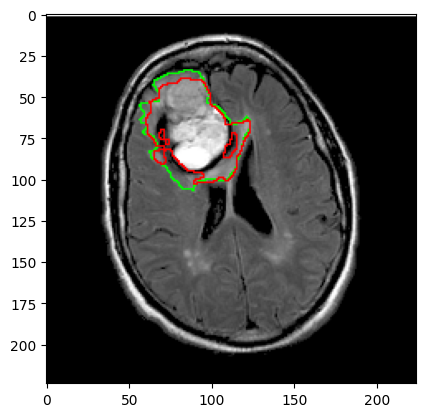

In [115]:
idx = 1
model.eval()  

pfigure = Image.open("model_comp_TCGA_HT_7616_19940813_y_true.png")
pfigure = np.array(pfigure)
# pfigure = Image.open("model_comp_TCGA_DU_7014_19860618_y_true.png")
# pfigure = np.array(pfigure)
# real_mask = Image.open("TCGA_DU_7014_19860618_30_mask.tif").resize((IMAGE_SIZE, IMAGE_SIZE))
# real_mask = np.array(real_mask)
# print(real_mask.shape)
image = Image.open(data_plot.iloc[idx, 0]).resize((IMAGE_SIZE, IMAGE_SIZE))
image = np.array(image)
sample = {"image": image}
inputs = valid_transforms(**sample)["image"].unsqueeze(0).to(device)

mask = Image.open(data_plot.iloc[idx, 1]).resize((IMAGE_SIZE, IMAGE_SIZE))
mask = np.array(mask)[..., np.newaxis]
mask1 = mask.copy()
pytorch_mask = torch.from_numpy(mask1)
reshaped_mask = pytorch_mask.permute(2,0,1)
# print(reshaped_mask.shape)
# print(inputs.shape)
reshaped_mask = reshaped_mask.to(device)

mask = np.squeeze(mask)


out = model(pixel_values=inputs, labels=reshaped_mask).logits
out = nn.functional.interpolate(out, size=(IMAGE_SIZE, IMAGE_SIZE), mode="bilinear", align_corners=False)
out = torch.sigmoid(out)

out = out.detach().cpu().numpy()[0]
out = np.where(out >= 0.5, 1, 0)
out = np.squeeze(out)
pfigure = outline(pfigure, out, color=[255, 0, 0])
plt.imshow(pfigure)
plt.show()
plt.close()

In [60]:
def test_all_plot(model):
    model.eval()
    for idx in range(len(x_test)):
        image = Image.open(x_test.iloc[idx, 0]).resize((IMAGE_SIZE, IMAGE_SIZE))
        image = np.array(image)
        sample = {"image": image}
        inputs = valid_transforms(**sample)["image"].unsqueeze(0).to(device)
        
        mask = Image.open(x_test.iloc[idx, 1]).resize((IMAGE_SIZE, IMAGE_SIZE))
        mask = np.array(mask)[..., np.newaxis]
        mask1 = mask.copy()
        pytorch_mask = torch.from_numpy(mask1)
        reshaped_mask = pytorch_mask.permute(2,0,1)
        # print(reshaped_mask.shape)
        # print(inputs.shape)
        reshaped_mask = reshaped_mask.to(device)
        mask = np.repeat(mask, 3, axis=-1)
        
        masked_image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)
        
       
        out = model(pixel_values=inputs, labels=reshaped_mask).logits
        out = nn.functional.interpolate(out, size=(IMAGE_SIZE, IMAGE_SIZE), mode="bilinear", align_corners=False)
        out = torch.sigmoid(out)
        out = out.detach().cpu().numpy()[0].transpose(1,2,0)
        out = np.where(out >= 0.5, 1, 0)
        out = np.clip(out * 255, 0, 255)
        out = np.repeat(out, 3, axis=-1).astype(np.uint8)

        out_image = cv2.addWeighted(image, 0.5, out, 0.5, 0)
        
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
        axes[0].imshow(image)
        axes[0].set_title("Image")
        axes[1].imshow(masked_image)
        axes[1].set_title("Original Mask")
        axes[2].imshow(out_image)
        axes[2].set_title("Predicted Mask")
        plt.tight_layout()
        plt.savefig(f'result_segformer/figure_{idx}.png')
        plt.close()

In [61]:
test_all_plot(model)

In [36]:
image1 = cv2.imread('model_comp_TCGA_DU_7014_19860618_y_true.png')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

image2 = cv2.imread('model_comp_TCGA_HT_7616_19940813_y_true.png')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

In [37]:
def outline(image, mask, color):
    mask = np.round(mask)
    yy, xx = np.nonzero(mask)
    for y, x in zip(yy, xx):
        if 0.0 < np.mean(mask[max(0, y - 1) : y + 2, max(0, x - 1) : x + 2]) < 1.0:
            image[max(0, y) : y + 1, max(0, x) : x + 1] = color
    return image


In [ ]:
image1 = np.array(image1)
sample = {"image": image}
inputs = valid_transforms(**sample)["image"].unsqueeze(0).to(device)

mask = Image.open(x_test.iloc[idx, 1]).resize((IMAGE_SIZE, IMAGE_SIZE))
mask = np.array(mask)[..., np.newaxis]
mask1 = mask.copy()
pytorch_mask = torch.from_numpy(mask1)
reshaped_mask = pytorch_mask.permute(2,0,1)
# print(reshaped_mask.shape)
# print(inputs.shape)
reshaped_mask = reshaped_mask.to(device)
mask = np.repeat(mask, 3, axis=-1)

masked_image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)


out = model(pixel_values=inputs, labels=reshaped_mask).logits
out = nn.functional.interpolate(out, size=(IMAGE_SIZE, IMAGE_SIZE), mode="bilinear", align_corners=False)
out = torch.sigmoid(out)
out = out.detach().cpu().numpy()[0].transpose(1,2,0)
out = np.where(out >= 0.5, 1, 0)
out = np.clip(out * 255, 0, 255)
out = np.repeat(out, 3, axis=-1).astype(np.uint8)

out_image = cv2.addWeighted(image, 0.5, out, 0.5, 0)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))

In [ ]:
image1 = outline(image1, y_pred1[s, 0], color=[255, 0, 0])
